## Imports

In [24]:
# Pytorch specific imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.datasets as datasets
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2

# Other imports
import kaggle
import albumentations as A # - This was installed via pip
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

## Setup Neural Networks

In [2]:
# This ConvNet could be used instead of the "ComplexCNN". It has less layers, and likely can detect less features, but is also less likely to overfit and faster
class CNN(nn.Module):
    def __init__(self, num_classes=2, dropout_prob=0.5):
        super(CNN, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Dropout layer after convolutional layers (optional)
        self.dropout_conv = nn.Dropout(p=dropout_prob/2)  # Typically, dropout in convolutional layers is kept lower

        # Fully connected layers
        self.fc1 = nn.Linear(32 * 64 * 64, 64)  # After 2 max-pooling operations, the size becomes (28/2/2 = 7)

        # Dropout layer for fully connected layers
        self.dropout_fc = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Conv layer 1 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)  # Reducing spatial dimensions by half
        x = self.dropout_conv(x)  # Dropout after pooling (optional)

        # Conv layer 2 with ReLU activation followed by MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)  # Reducing spatial dimensions by half
        x = self.dropout_conv(x)  # Dropout after pooling (optional)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Dropout after activation
        x = self.fc2(x)

        return x

In [3]:
# This ConvNet is more complex with more layers than the "standard" ConvNet defined above
class ComplexCNN(nn.Module):
def __init__(self, dropout_prob=0.5):
        super(ComplexCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.dropout_conv = nn.Dropout(p=dropout_prob/2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 1)  # For binary classification

        self.dropout_fc = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        x = F.leaky_relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout_conv(x)

        # Flatten
        x = x.view(x.size(0), -1)

        x = F.leaky_relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.dropout_fc(x)
        x = F.leaky_relu(self.fc3(x))
        x = self.dropout_fc(x)
        x = F.leaky_relu(self.fc4(x))
        x = self.dropout_fc(x)
        x = self.fc5(x)

        return x

## Set Up Device Agnostic Code

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hyperparamters

In [5]:
input_size = 784
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 12

## Data
- Load Data
- Split Data
- Apply transformations

In [6]:
class AlbumentationsTransform:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, image):
        # Convert PIL image to numpy array
        image_np = np.array(image)

        # Apply transformations
        augmented = self.transform(image=image_np)

        # Convert numpy image back to PyTorch tensor, normalize and permute
        image_tensor = torch.tensor(augmented['image'], dtype=torch.float32).permute(2, 0, 1) / 255.0

        return image_tensor

In [7]:
# Using data augmentation with the albumentations library
augmentation = A.Compose([
    A.Resize(128, 128),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(p=0.3),
    A.CLAHE(p=0.3),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.3),
    A.GaussNoise(p=0.1),
    A.GaussianBlur(p=0.1),
    A.OpticalDistortion(p=0.05),
    A.GridDistortion(p=0.05),
    # A.ToTensorV2()  # Convert the image to PyTorch tensor. It should be the last transform.
])

test_augmentation = A.Compose([
    A.Resize(128, 128)
])

wrapped_augmentation = transforms.Compose([
    AlbumentationsTransform(augmentation),
    transforms.ToTensor()
])

wrapped_test_augmentation = transforms.Compose([
    AlbumentationsTransform(test_augmentation),
    transforms.ToTensor()
])

In [8]:
wrapped_augmentation = AlbumentationsTransform(augmentation)
wrapped_test_augmentation = AlbumentationsTransform(test_augmentation)

In [12]:
class CustomDataset(Dataset):
    def __init__(self, dataset, root, transform=None):
        self.dataset = dataset
        self.root = root
        self.augmentations = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        # Get an image and its label
        path, target = self.dataset.dataset.samples[self.dataset.indices[index]]
        image = Image.open(path).convert("RGB")

        # Apply albumentations
        if self.augmentations:
            image = self.augmentations(image)

        return image, target


In [13]:

root_directory = '/Users/jacob/OneDrive/Desktop/Aletheia/Dataset_1/'
# Load the entire dataset without any transformations
full_dataset = datasets.ImageFolder(root=root_directory)

# Split the dataset into train and test
train_size = int(0.8 * len(full_dataset))  # 80%
test_size = len(full_dataset) - train_size
train_subset, test_subset = random_split(full_dataset, [train_size, test_size])

# Apply the transformations using the CustomDataset class
train_dataset = CustomDataset(train_subset, root=root_directory, transform=wrapped_augmentation)
test_dataset = CustomDataset(test_subset, root=root_directory, transform=wrapped_test_augmentation)

# Create data loaders
batch_size = 64  # Adjust as per your need

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Explore and Visualize Data

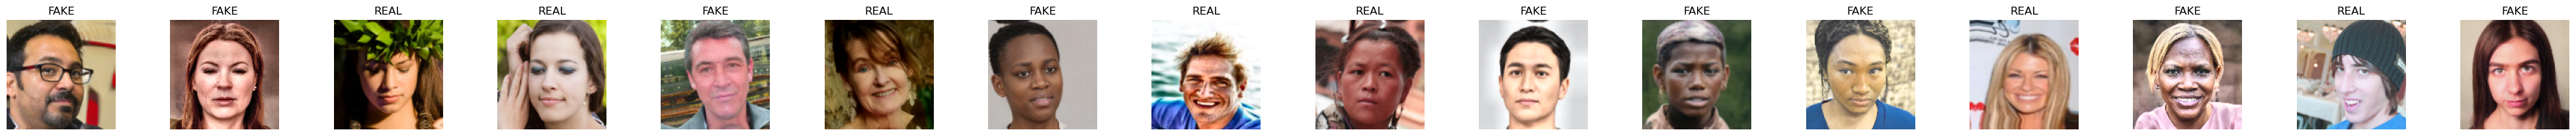

In [36]:
def imshow_with_labels(dataloader, class_names, num_images=16):
    """Display a batch of images with labels."""
    images, labels = next(iter(dataloader))
    
    fig, axes = plt.subplots(1, num_images, figsize=(50, 50), 
                             subplot_kw={'xticks':[], 'yticks':[], 'frame_on':False})
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    for ax, img, lbl in zip(axes, images, labels):
        img = img.numpy().transpose((1, 2, 0))
        ax.imshow(img)
        ax.set_title(class_names[lbl])
    
    plt.show()

# Using the function to display a batch
imshow_with_labels(train_loader, class_names=full_dataset.classes)

## Training

### Prepare Training

In [20]:
torch.manual_seed(42)
model = ComplexCNN().to(device)

In [37]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.NAdam(model.parameters(), lr=learning_rate)

In [38]:
writer = SummaryWriter(f'runs/MNIST/tryingout_tensorboard')
step = 0

### Train Model

In [39]:
num_correct = 0
num_samples = 0
torch.manual_seed(46)

model = model.to(device=device)
log_interval = 100

for epoch in range(num_epochs):
  model.train()
  for batch_idx, (data, targets) in enumerate(train_loader):
    # Move data and targets to the device
    data = data.to(device=device)
    targets = targets.to(device=device)

    # Forward pass
    scores = model(data)
    scores = scores.squeeze(1)
    loss = criterion(scores.view(-1), targets.float())
    # print(loss.item())

    # Backward pass
    optimizer.zero_grad()
    loss.backward()

    # Gradient descent (or whatever optimizer you're using)
    optimizer.step()

    predictions = (torch.sigmoid(scores) > 0.5).float()
    num_correct += (predictions == targets).sum().item()
    num_samples += predictions.size(0)

    accuracy = 100 * num_correct / num_samples

    # Log the metrics to TensorBoard
    if batch_idx % log_interval == 0:
      writer.add_scalar('Training Loss', loss, epoch * len(train_loader) + batch_idx)
      writer.add_scalar('Training Accuracy', accuracy, epoch * len(train_loader) + batch_idx)
      print("Epoch: ", epoch)
      print(f'Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')

  print("~!!1!!!!!!Epoch: ", epoch)

  print(f'!!!!!!!!!!Got {num_correct} / {num_samples} with accuracy {accuracy:.2f}')

torch.save(model.state_dict(), f'/Users/jacob/OneDrive/Desktop/Aletheia/Version1_0/state_dicts/model_epoch_{epoch}_num_correct{num_correct}.pth')

Epoch:  0
Got 50 / 64 with accuracy 78.12


KeyboardInterrupt: 

## Testing the Model

In [270]:
def check_accuracy(loader, model):
    print(type(loader))
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x)
            predictions = (torch.sigmoid(scores) > 0.5).squeeze().long()
            num_correct += (predictions == y).sum().item()
            num_samples += predictions.size(0)
            # print(f"y shape: {y.shape}")
            # print(f"y values: {y.unique()}")
            # print(f"predictions shape: {predictions.shape}")
            # print(f"predictions values: {predictions.unique()}")

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

    model.train()

# check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

<class 'torch.utils.data.dataloader.DataLoader'>
Got 50179 / 54742 with accuracy 91.66
